In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Setup and Data Loading with Quantile Binning**

In [1]:
# --- INSTALLING LIBRARIES ---
!pip install --upgrade transformers accelerate datasets scikit-learn protobuf==3.20.3 -q

# --- IMPORTING LIBRARIES ---
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, TrainingArguments, Trainer, DistilBertModel
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, OneHotEncoder, LabelEncoder
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
warnings.filterwarnings('ignore')

RNG = 42



FILE_PATH = '/kaggle/input/non-english-review-removed-dataset/Non English reviews deleted All_Language_Data - Copy.csv'




# Check if file exists and list available files
if not os.path.exists(FILE_PATH):
    print("File not found! Available directories:")
    print("\nIn /kaggle/input/:")
    if os.path.exists('/kaggle/input'):
        for item in os.listdir('/kaggle/input'):
            print(f"  - {item}")
            item_path = os.path.join('/kaggle/input', item)
            if os.path.isdir(item_path):
                print(f"    Files in {item}:")
                for file in os.listdir(item_path):
                    print(f"      * {file}")
    
    print("\nIn /kaggle/working/:")
    if os.path.exists('/kaggle/working'):
        for item in os.listdir('/kaggle/working'):
            print(f"  - {item}")
    
    print("\n⚠️  Please update FILE_PATH variable with the correct path from above")
    raise FileNotFoundError(f"Dataset not found at {FILE_PATH}")

# --- LOADING THE DATASET ---
print(f"Loading dataset from: {FILE_PATH}")
df = pd.read_csv(FILE_PATH)
print(f"✓ Dataset loaded. Shape: {df.shape}")

# quick sanity check
needed_cols = [
    'title', 'reviewText', 'originalScore', 'tomatoMeter', 'genre',
    'audienceScore', 'runtimeMinutes', 'language_encoded', 'director_encoded'
]
missing = [c for c in needed_cols if c not in df.columns]
assert not missing, f"Missing columns in CSV: {missing}"
print("✓ All required columns present")

# --- CLEAN MINIMUMS ---
print("\nCleaning data...")
original_size = len(df)
df = df.dropna(subset=['reviewText', 'originalScore']).copy()
print(f"Removed {original_size - len(df)} rows with missing data")

# --- CREATE MULTICLASS LABELS USING QUANTILE BINNING ---
print("\n" + "="*60)
print("Creating multiclass labels using QUANTILE binning...")
print("="*60)

# First, create a rank column to ensure equal distribution
df['originalScore_rank'] = df['originalScore'].rank(method='first')

# Use quantile binning on the rank for perfectly balanced classes
df['sentiment_multiclass'] = pd.qcut(
    df['originalScore_rank'], 
    q=5, 
    labels=["Very Negative", "Negative", "Average", "Positive", "Very Positive"]
)

# Drop the temporary rank column
df = df.drop('originalScore_rank', axis=1)

# Encode labels to integers
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['sentiment_multiclass'])

# Verify the distribution
print("\n=== Multiclass Label Distribution ===")
label_dist = df['sentiment_multiclass'].value_counts().sort_index()
print(label_dist)

print("\n=== Score Ranges per Class ===")
score_ranges = df.groupby('sentiment_multiclass')['originalScore'].agg(['min', 'max', 'mean', 'count'])
score_ranges = score_ranges.reindex(["Very Negative", "Negative", "Average", "Positive", "Very Positive"])
print(score_ranges)

print("\n=== Label Encoding Mapping ===")
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{i}: {class_name}")

# Class names for reporting
class_names = list(label_encoder.classes_)
num_labels = len(class_names)

print(f"\n✓ Created {num_labels} classes: {class_names}")

# Text fields
df['title'] = df['title'].fillna("")
df['genre'] = df['genre'].fillna("Unknown")
df['combined_text'] = df['title'] + " [SEP] " + df['reviewText']

print("\n✓ Data preparation complete")
print("="*60)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 96.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.8/375.8 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 106.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 37.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 73.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB

2025-11-16 09:28:48.737562: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763285328.964338      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763285329.028982      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Loading dataset from: /kaggle/input/non-english-review-removed-dataset/Non English reviews deleted All_Language_Data - Copy.csv
✓ Dataset loaded. Shape: (194801, 10)
✓ All required columns present

Cleaning data...
Removed 0 rows with missing data

Creating multiclass labels using QUANTILE binning...

=== Multiclass Label Distribution ===
sentiment_multiclass
Very Negative    38961
Negative         38960
Average          38960
Positive         38960
Very Positive    38960
Name: count, dtype: int64

=== Score Ranges per Class ===
                       min    max      mean  count
sentiment_multiclass                              
Very Negative         0.00   4.00  2.884515  38961
Negative              4.00   5.00  4.621480  38960
Average               5.00   6.25  5.872927  38960
Positive              6.25   8.00  7.138049  38960
Very Positive         8.00  10.00  8.645944  38960

=== Label Encoding Mapping ===
0: Average
1: Negative
2: Positive
3: Very Negative
4: Very Positive

✓ Crea

**Stratified Split and Preprocessing**

In [6]:
# --- STRATIFIED SPLIT ---
print("\n=== Performing Stratified Train-Test Split ===")
train_idx, test_idx = train_test_split(
    df.index, test_size=0.2, random_state=RNG, stratify=df['label']
)
train_df = df.loc[train_idx].reset_index(drop=True)
test_df  = df.loc[test_idx].reset_index(drop=True)

y_train = train_df['label'].values.astype(int)
y_test  = test_df['label'].values.astype(int)

print(f"Train size: {len(train_df)} | Test size: {len(test_df)}")
print("\nTrain label distribution:")
print(train_df['sentiment_multiclass'].value_counts().sort_index())
print("\nTest label distribution:")
print(test_df['sentiment_multiclass'].value_counts().sort_index())

# ============ FIT PREPROCESSORS ON TRAIN ONLY ============

# --- Numeric: fill NA with train medians, then scale ---
NUMERIC_COLS = ['tomatoMeter', 'audienceScore', 'runtimeMinutes']
train_numeric = train_df[NUMERIC_COLS].copy()
train_medians = train_numeric.median(numeric_only=True)
train_numeric = train_numeric.fillna(train_medians)

scaler = StandardScaler()
scaler.fit(train_numeric.values)

# --- Categorical: genre (multi-label) ---
train_genre_list = train_df['genre'].fillna("Unknown").str.split(', ')
mlb = MultiLabelBinarizer()
mlb.fit(train_genre_list)

# --- language_encoded: One-Hot ---
import sklearn
from packaging import version

train_lang = train_df['language_encoded'].astype('Int64').astype(str).fillna('unknown')

if version.parse(sklearn.__version__) >= version.parse("1.2"):
    ohe_lang = OneHotEncoder(handle_unknown='ignore', sparse_output=False, dtype=np.float32)
else:
    ohe_lang = OneHotEncoder(handle_unknown='ignore', sparse=False, dtype=np.float32)

ohe_lang.fit(train_lang.to_frame())


=== Performing Stratified Train-Test Split ===
Train size: 155840 | Test size: 38961

Train label distribution:
sentiment_multiclass
Very Negative    31168
Negative         31168
Average          31168
Positive         31168
Very Positive    31168
Name: count, dtype: int64

Test label distribution:
sentiment_multiclass
Very Negative    7793
Negative         7792
Average          7792
Positive         7792
Very Positive    7792
Name: count, dtype: int64


,categories,'auto'
,drop,None
,sparse_output,False
,dtype,<class 'numpy.float32'>
,handle_unknown,'ignore'
,min_frequency,None
,max_categories,None
,feature_name_combiner,'concat'


**Director Features with Class Weights**

In [7]:
# --- director_encoded: Frequency + K-fold target mean (multiclass-aware) ---
def director_features_multiclass(train_s: pd.Series, y: np.ndarray, test_s: pd.Series, 
                                  num_classes: int, n_splits: int = 5):
    """
    Leak-safe target encoding for multiclass with frequency feature.
    Creates one target-mean column per class.
    """
    s_train = train_s.fillna("Unknown").astype(str)
    s_test  = test_s.fillna("Unknown").astype(str)
    
    # Frequency (log1p) using TRAIN counts only
    freq = s_train.value_counts()
    tr_freq = s_train.map(freq).fillna(0).astype(float).values
    te_freq = s_test.map(freq).fillna(0).astype(float).values
    tr_freq = np.log1p(tr_freq)[:, None].astype(np.float32)
    te_freq = np.log1p(te_freq)[:, None].astype(np.float32)
    
    # K-fold target mean for each class
    tr_te_list = []
    te_te_list = []
    
    for class_idx in range(num_classes):
        # Binary indicator: 1 if this class, 0 otherwise
        y_binary = (y == class_idx).astype(float)
        global_mean = y_binary.mean()
        
        skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RNG)
        tr_te = np.zeros(len(s_train), dtype=np.float32)
        
        for tr_i, val_i in skf.split(np.zeros(len(y)), y):
            tr_part = s_train.iloc[tr_i]
            y_part  = y_binary[tr_i]
            
            # mean per director on fold-train
            means = pd.Series(y_part, index=tr_part).groupby(tr_part).mean()
            tr_te[val_i] = s_train.iloc[val_i].map(means).fillna(global_mean).astype(np.float32).values
        
        tr_te_list.append(tr_te[:, None])
        
        # Test target mean: compute on FULL train
        full_means = pd.Series(y_binary, index=s_train).groupby(s_train).mean()
        te_te = s_test.map(full_means).fillna(global_mean).astype(np.float32).values[:, None]
        te_te_list.append(te_te)
    
    # Concatenate: [freq, te_class0, te_class1, ..., te_class4]
    tr_te_concat = np.concatenate(tr_te_list, axis=1)
    te_te_concat = np.concatenate(te_te_list, axis=1)
    
    return tr_freq, te_freq, tr_te_concat, te_te_concat

# Generate director features
if 'director' in train_df.columns:
    dtr_f, dte_f, dtr_te, dte_te = director_features_multiclass(
        train_df['director'], y_train, test_df['director'], num_labels
    )
else:
    dtr_f, dte_f, dtr_te, dte_te = director_features_multiclass(
        train_df['director_encoded'].astype(str), y_train,
        test_df['director_encoded'].astype(str), num_labels
    )

# Final director block = [freq, target_mean_class0, ..., target_mean_class4]
dir_train_block = np.concatenate([dtr_f, dtr_te], axis=1).astype(np.float32)
dir_test_block  = np.concatenate([dte_f, dte_te], axis=1).astype(np.float32)

print(f"\nDirector features shape: {dir_train_block.shape}")


Director features shape: (155840, 6)


**Feature Building and Dataset Creation**

In [8]:
def build_features(split_df: pd.DataFrame, dir_block: np.ndarray):
    out = {}
    out['combined_text'] = split_df['combined_text'].tolist()
    out['label'] = split_df['label'].astype(int).tolist()
    
    # numeric → fill with TRAIN medians, then TRAIN scaler
    numeric = split_df[NUMERIC_COLS].copy().fillna(train_medians)
    numeric_scaled = scaler.transform(numeric.values).astype(np.float32)
    out['numerical_features'] = [row for row in numeric_scaled]
    
    # genre multi-hot
    genre_list = split_df['genre'].fillna("Unknown").str.split(', ')
    genre_bin = mlb.transform(genre_list).astype(np.float32)
    
    # language one-hot
    lang = split_df['language_encoded'].astype('Int64').astype(str).fillna('unknown')
    lang_ohe = ohe_lang.transform(lang.to_frame()).astype(np.float32)
    
    # concatenate all categorical
    cat = np.concatenate([genre_bin, lang_ohe, dir_block], axis=1).astype(np.float32)
    out['categorical_features'] = [row for row in cat]
    return out

train_feats = build_features(train_df, dir_train_block)
test_feats  = build_features(test_df,  dir_test_block)

# sizes for the classifier head
num_numerical_features = 3
num_genre = len(mlb.classes_)
num_lang  = ohe_lang.get_feature_names_out().shape[0]
num_dir_enc = 1 + num_labels  # frequency + one target-mean per class
num_categorical_features = num_genre + num_lang + num_dir_enc

print(f"\n=== Feature Dimensions ===")
print(f"Numeric: {num_numerical_features}")
print(f"Genre: {num_genre}")
print(f"Language: {num_lang}")
print(f"Director: {num_dir_enc}")
print(f"Total Categorical: {num_categorical_features}")

# --- Wrap into DataFrames for HF ---
final_train_df = pd.DataFrame({
    'combined_text': train_feats['combined_text'],
    'label': train_feats['label'],
    'numerical_features': train_feats['numerical_features'],
    'categorical_features': train_feats['categorical_features'],
})
final_test_df = pd.DataFrame({
    'combined_text': test_feats['combined_text'],
    'label': test_feats['label'],
    'numerical_features': test_feats['numerical_features'],
    'categorical_features': test_feats['categorical_features'],
})

# --- HF Dataset ---
raw_multimodal_datasets = DatasetDict({
    'train': Dataset.from_pandas(final_train_df),
    'test':  Dataset.from_pandas(final_test_df),
})

# --- TOKENIZATION ---
MODEL_CHECKPOINT = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)

def tokenize_multimodal_function(examples):
    return tokenizer(examples["combined_text"], padding="max_length", truncation=True, max_length=256)

tokenized_multimodal_datasets = raw_multimodal_datasets.map(tokenize_multimodal_function, batched=True)

cols_to_remove = [c for c in ["combined_text", "__index_level_0__"] if c in tokenized_multimodal_datasets["train"].column_names]
tokenized_multimodal_datasets = tokenized_multimodal_datasets.remove_columns(cols_to_remove)
tokenized_multimodal_datasets.set_format("torch")


=== Feature Dimensions ===
Numeric: 3
Genre: 32
Language: 14
Director: 6
Total Categorical: 52


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/155840 [00:00<?, ? examples/s]

Map:   0%|          | 0/38961 [00:00<?, ? examples/s]

**Model Definition with Class Weights**

In [10]:
# --- COMPUTE CLASS WEIGHTS FOR IMBALANCED DATA ---
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)

print(f"\n=== Class Weights ===")
for i, (name, weight) in enumerate(zip(class_names, class_weights)):
    print(f"{name}: {weight:.4f}")

# --- MODEL ---
class MultimodalMulticlassClassifier(nn.Module):
    def __init__(self, num_labels, num_numerical_features, num_categorical_features, class_weights=None):
        super(MultimodalMulticlassClassifier, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained(MODEL_CHECKPOINT)
        self.dropout = nn.Dropout(0.3)  # Slightly higher dropout for multiclass
        self.classifier = nn.Linear(
            self.distilbert.config.hidden_size + num_numerical_features + num_categorical_features,
            num_labels
        )
        self.num_labels = num_labels
        self.class_weights = class_weights
    
    def forward(self, input_ids, attention_mask, numerical_features, categorical_features, labels=None):
        distilbert_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        cls_token_output = distilbert_output.last_hidden_state[:, 0]
        pooled_output = self.dropout(cls_token_output)
        
        combined_features = torch.cat([pooled_output, numerical_features, categorical_features], dim=1)
        logits = self.classifier(combined_features)
        
        loss = None
        if labels is not None:
            if self.class_weights is not None:
                # Move class weights to same device as model
                weights = self.class_weights.to(logits.device)
                loss_fct = nn.CrossEntropyLoss(weight=weights)
            else:
                loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        return (loss, logits) if loss is not None else (None, logits)

# --- DATA COLLATOR ---
class MultimodalDataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
    
    def __call__(self, features):
        batch = self.tokenizer.pad(
            [{"input_ids": f["input_ids"], "attention_mask": f["attention_mask"]} for f in features],
            return_tensors="pt"
        )
        numerical_features = np.stack([np.array(f['numerical_features'], dtype=np.float32) for f in features])
        categorical_features = np.stack([np.array(f['categorical_features'], dtype=np.float32) for f in features])
        batch['labels'] = torch.tensor([int(f['label']) for f in features], dtype=torch.long)
        batch['numerical_features'] = torch.tensor(numerical_features, dtype=torch.float32)
        batch['categorical_features'] = torch.tensor(categorical_features, dtype=torch.float32)
        return batch

# --- INIT MODEL & COLLATOR ---
multimodal_model = MultimodalMulticlassClassifier(
    num_labels=num_labels,
    num_numerical_features=num_numerical_features,
    num_categorical_features=num_categorical_features,
    class_weights=class_weights_tensor
)
data_collator = MultimodalDataCollator(tokenizer)


=== Class Weights ===
Average: 1.0000
Negative: 1.0000
Positive: 1.0000
Very Negative: 1.0000
Very Positive: 1.0000


**Metrics and Training**

In [11]:
# --- METRICS ---
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions[0].argmax(-1) if isinstance(pred.predictions, tuple) else pred.predictions.argmax(-1)
    
    # Macro average for multiclass
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)
    acc = accuracy_score(labels, preds)
    
    # Also compute weighted metrics
    precision_w, recall_w, f1_w, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    
    return {
        'accuracy': acc,
        'f1_macro': f1,
        'precision_macro': precision,
        'recall_macro': recall,
        'f1_weighted': f1_w,
        'precision_weighted': precision_w,
        'recall_weighted': recall_w
    }

# --- TRAINING ARGS ---
multimodal_training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/THESIS 47/Saved Datasets/results_multiclass_multimodal_ALL_FEATURES",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,  # More epochs for multiclass
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    logging_steps=50,
    logging_dir="/content/drive/MyDrive/THESIS 47/Saved Datasets/logs_multiclass",
    report_to="none"  # Disable wandb if you don't use it
)

# --- TRAINER ---
multimodal_trainer = Trainer(
    model=multimodal_model,
    args=multimodal_training_args,
    train_dataset=tokenized_multimodal_datasets["train"],
    eval_dataset=tokenized_multimodal_datasets["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# --- TRAIN ---
print("\n" + "="*60)
print("STARTING TRAINING: Multimodal Multiclass Model")
print("="*60)
print(f"Model: DistilBERT + All Features")
print(f"Classes: {num_labels} ({', '.join(class_names)})")
print(f"Train size: {len(tokenized_multimodal_datasets['train'])}")
print(f"Test size: {len(tokenized_multimodal_datasets['test'])}")
print("="*60 + "\n")

multimodal_trainer.train()

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



STARTING TRAINING: Multimodal Multiclass Model
Model: DistilBERT + All Features
Classes: 5 (Average, Negative, Positive, Very Negative, Very Positive)
Train size: 155840
Test size: 38961



Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro,F1 Weighted,Precision Weighted,Recall Weighted
1,1.192700,1.173341,0.474936,0.469326,0.469692,0.474934,0.469328,0.469694,0.474936
2,1.085300,1.152545,0.486563,0.475935,0.477891,0.486561,0.475937,0.477894,0.486563
3,0.993100,1.192382,0.484895,0.479230,0.485349,0.484893,0.479232,0.485352,0.484895
4,0.922100,1.266665,0.480917,0.480711,0.482781,0.480915,0.480713,0.482784,0.480917
5,0.789500,1.347175,0.477118,0.477737,0.480850,0.477117,0.477739,0.480853,0.477118


TrainOutput(global_step=24350, training_loss=0.9977621051075523, metrics={'train_runtime': 11280.4629, 'train_samples_per_second': 69.075, 'train_steps_per_second': 2.159, 'total_flos': 0.0, 'train_loss': 0.9977621051075523, 'epoch': 5.0})

**Evaluation and Visualization**


EVALUATION: Multiclass Multimodal Model


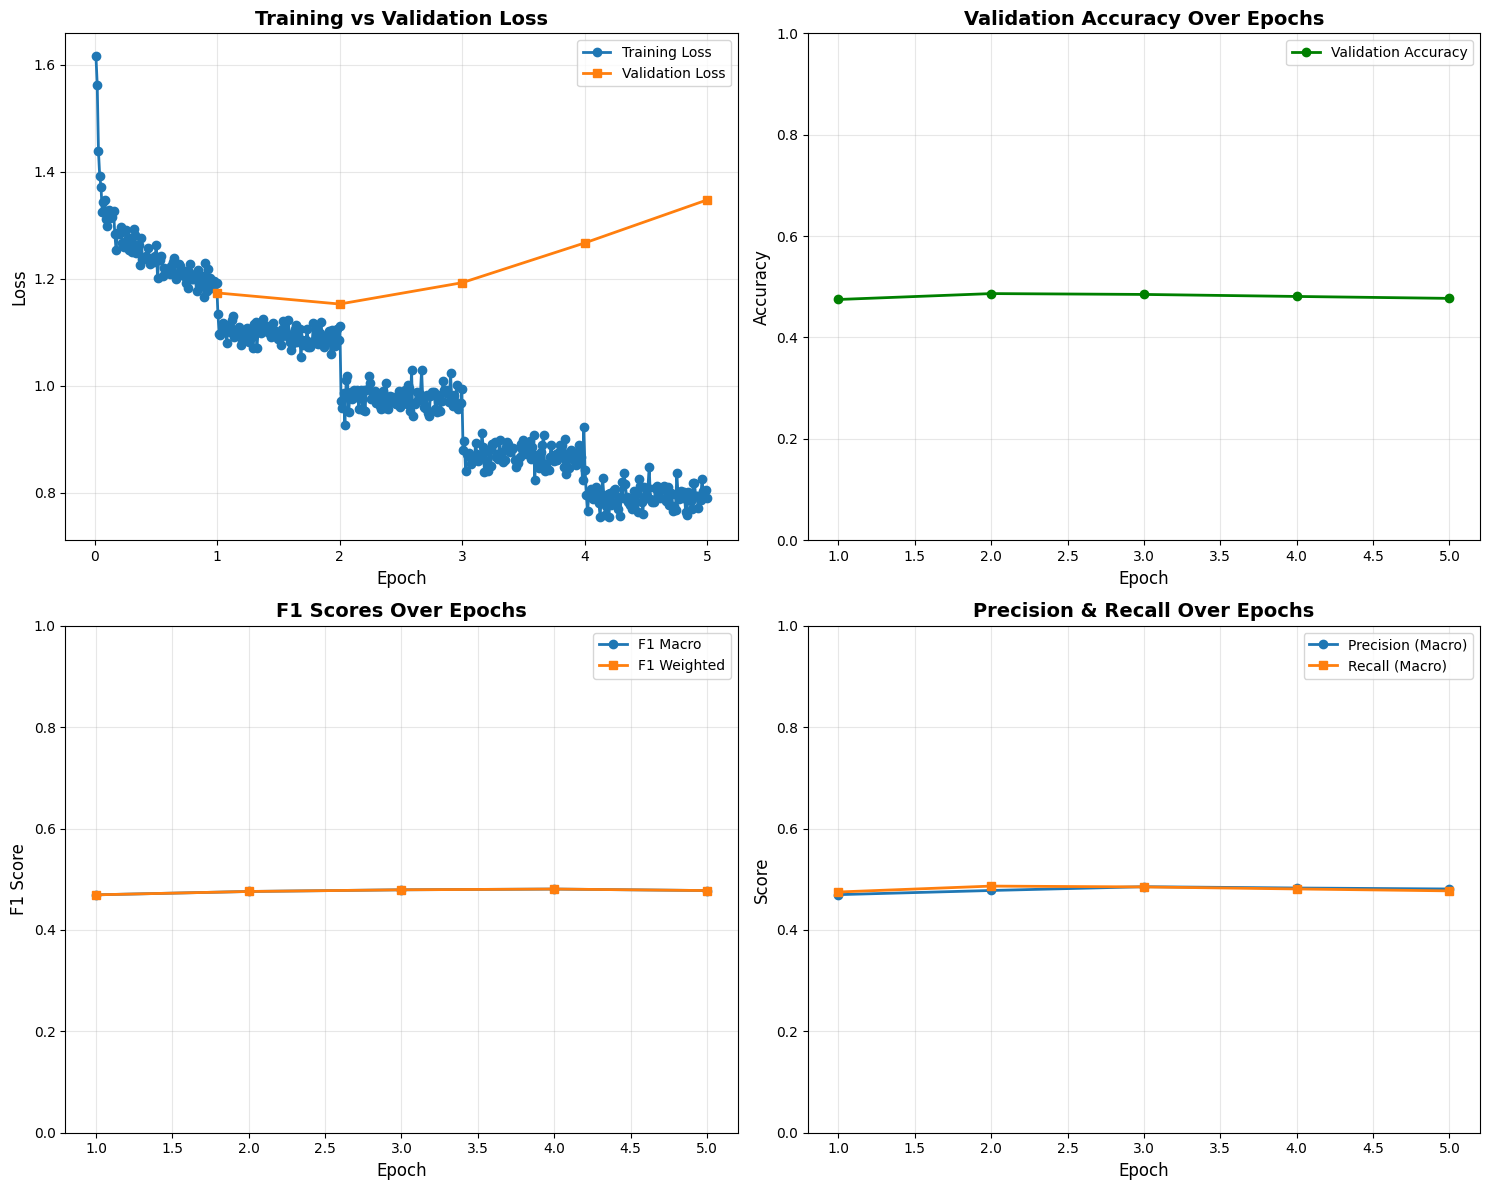


--- Final Evaluation on Test Set ---


eval_loss: 1.2667
eval_accuracy: 0.4809
eval_f1_macro: 0.4807
eval_precision_macro: 0.4828
eval_recall_macro: 0.4809
eval_f1_weighted: 0.4807
eval_precision_weighted: 0.4828
eval_recall_weighted: 0.4809
eval_runtime: 178.1416
eval_samples_per_second: 218.7080
eval_steps_per_second: 6.8370
epoch: 5.0000

Predictions shape: (38961,)
True labels shape: (38961,)


In [12]:
# ==========================
# EVALUATE • REPORT • PLOTS • SAVE (Multiclass)
# ==========================

print("\n" + "="*60)
print("EVALUATION: Multiclass Multimodal Model")
print("="*60)

# --- Training Curves ---
log_history = multimodal_trainer.state.log_history
train_logs = [log for log in log_history if ('loss' in log and 'eval_loss' not in log)]
eval_logs = [log for log in log_history if ('eval_loss' in log)]

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Loss curves
axes[0, 0].plot([log.get('epoch', i) for i, log in enumerate(train_logs, 1)],
                [log['loss'] for log in train_logs], 
                label='Training Loss', marker='o', linewidth=2)
axes[0, 0].plot([log.get('epoch', i) for i, log in enumerate(eval_logs, 1)],
                [log['eval_loss'] for log in eval_logs], 
                label='Validation Loss', marker='s', linewidth=2)
axes[0, 0].set_xlabel('Epoch', fontsize=12)
axes[0, 0].set_ylabel('Loss', fontsize=12)
axes[0, 0].set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# Accuracy curve
if len(eval_logs) > 0 and 'eval_accuracy' in eval_logs[0]:
    axes[0, 1].plot([log.get('epoch', i) for i, log in enumerate(eval_logs, 1)],
                    [log['eval_accuracy'] for log in eval_logs], 
                    label='Validation Accuracy', marker='o', color='green', linewidth=2)
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('Accuracy', fontsize=12)
    axes[0, 1].set_title('Validation Accuracy Over Epochs', fontsize=14, fontweight='bold')
    axes[0, 1].legend(fontsize=10)
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_ylim([0, 1])

# F1 curves (macro and weighted)
if len(eval_logs) > 0 and 'eval_f1_macro' in eval_logs[0]:
    axes[1, 0].plot([log.get('epoch', i) for i, log in enumerate(eval_logs, 1)],
                    [log['eval_f1_macro'] for log in eval_logs], 
                    label='F1 Macro', marker='o', linewidth=2)
    if 'eval_f1_weighted' in eval_logs[0]:
        axes[1, 0].plot([log.get('epoch', i) for i, log in enumerate(eval_logs, 1)],
                        [log['eval_f1_weighted'] for log in eval_logs], 
                        label='F1 Weighted', marker='s', linewidth=2)
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('F1 Score', fontsize=12)
    axes[1, 0].set_title('F1 Scores Over Epochs', fontsize=14, fontweight='bold')
    axes[1, 0].legend(fontsize=10)
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_ylim([0, 1])

# Precision and Recall curves
if len(eval_logs) > 0 and 'eval_precision_macro' in eval_logs[0]:
    axes[1, 1].plot([log.get('epoch', i) for i, log in enumerate(eval_logs, 1)],
                    [log['eval_precision_macro'] for log in eval_logs], 
                    label='Precision (Macro)', marker='o', linewidth=2)
    axes[1, 1].plot([log.get('epoch', i) for i, log in enumerate(eval_logs, 1)],
                    [log['eval_recall_macro'] for log in eval_logs], 
                    label='Recall (Macro)', marker='s', linewidth=2)
    axes[1, 1].set_xlabel('Epoch', fontsize=12)
    axes[1, 1].set_ylabel('Score', fontsize=12)
    axes[1, 1].set_title('Precision & Recall Over Epochs', fontsize=14, fontweight='bold')
    axes[1, 1].legend(fontsize=10)
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].set_ylim([0, 1])

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/THESIS 47/Saved Datasets/multiclass_training_curves.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# --- Final Evaluation ---
print("\n--- Final Evaluation on Test Set ---")
multimodal_eval_results = multimodal_trainer.evaluate()
for key, value in multimodal_eval_results.items():
    print(f"{key}: {value:.4f}")

# --- Get Predictions ---
pred_out = multimodal_trainer.predict(tokenized_multimodal_datasets["test"])
logits = pred_out.predictions[0] if isinstance(pred_out.predictions, (list, tuple)) else pred_out.predictions
logits = np.asarray(logits)
multimodal_predicted_labels = np.argmax(logits, axis=-1)
true_labels = np.asarray(tokenized_multimodal_datasets["test"]["label"]).astype(int)

print(f"\nPredictions shape: {multimodal_predicted_labels.shape}")
print(f"True labels shape: {true_labels.shape}")

**Classification Report and Confusion Matrices**


CLASSIFICATION REPORT
               precision    recall  f1-score   support

      Average     0.3743    0.3247    0.3477      7792
     Negative     0.4090    0.4722    0.4383      7792
     Positive     0.4228    0.4487    0.4354      7792
Very Negative     0.5899    0.5364    0.5619      7793
Very Positive     0.6179    0.6227    0.6203      7792

     accuracy                         0.4809     38961
    macro avg     0.4828    0.4809    0.4807     38961
 weighted avg     0.4828    0.4809    0.4807     38961



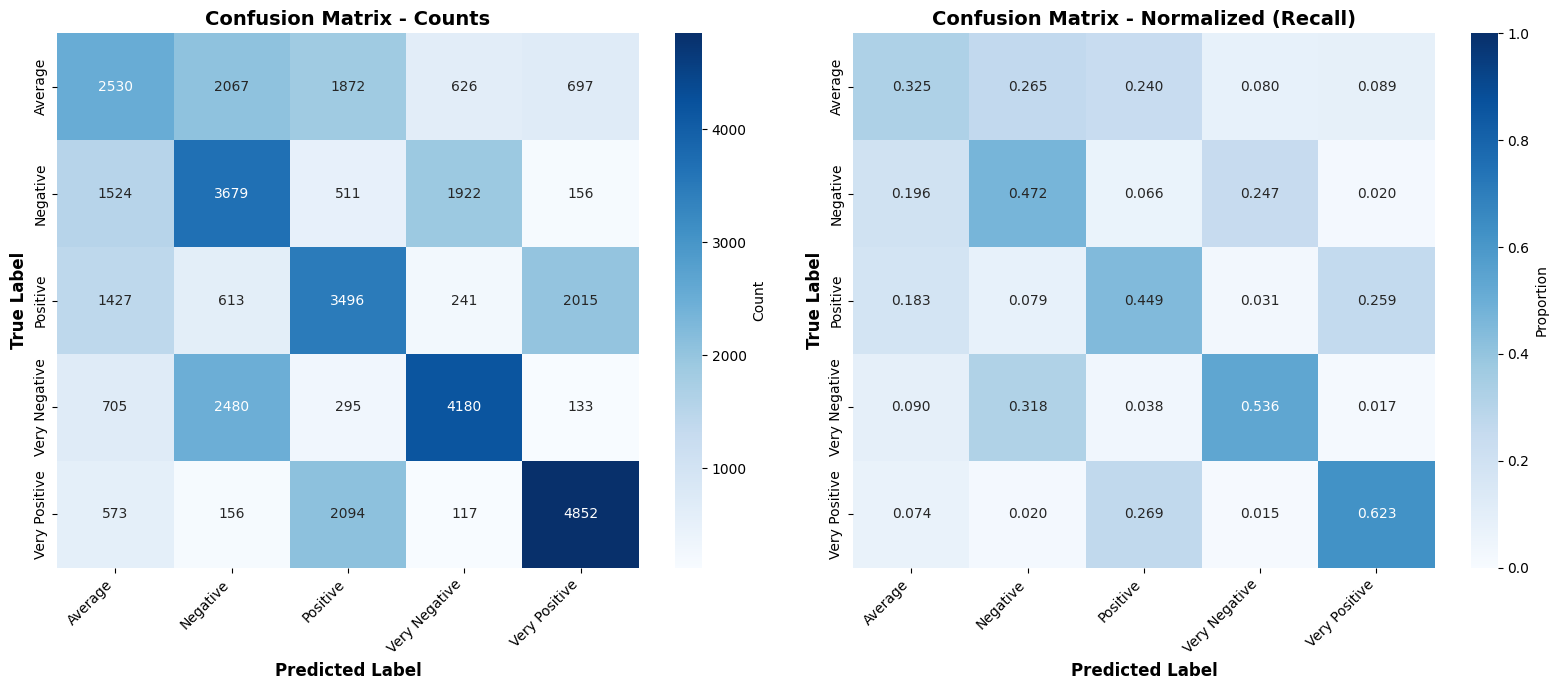

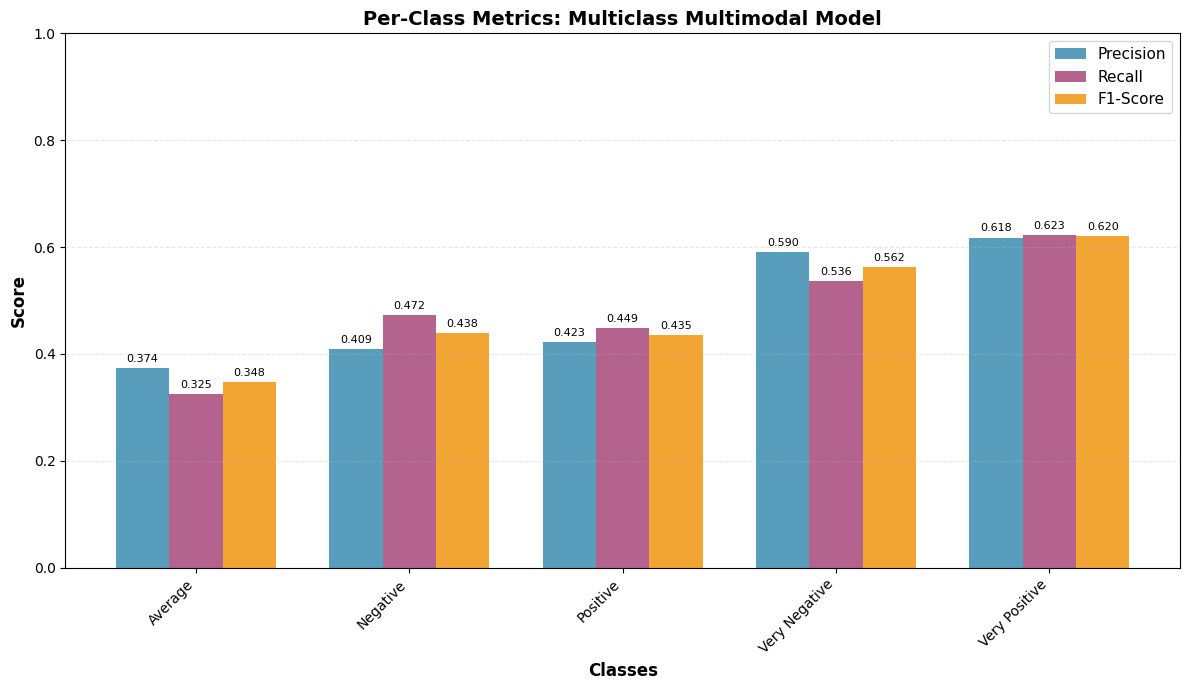

In [13]:
# --- Classification Report ---
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
report_text = classification_report(true_labels, multimodal_predicted_labels,
                                    target_names=class_names, zero_division=0, digits=4)
print(report_text)

report_dict = classification_report(true_labels, multimodal_predicted_labels,
                                    target_names=class_names, output_dict=True, zero_division=0)

# Save report to file
with open('/content/drive/MyDrive/THESIS 47/Saved Datasets/multiclass_classification_report.txt', 'w') as f:
    f.write("="*60 + "\n")
    f.write("MULTICLASS CLASSIFICATION REPORT\n")
    f.write("="*60 + "\n\n")
    f.write(report_text)

# --- Confusion Matrices ---
cm = confusion_matrix(true_labels, multimodal_predicted_labels, labels=list(range(num_labels)))
row_sums = cm.sum(axis=1, keepdims=True)
row_sums[row_sums == 0] = 1
cm_norm = cm.astype('float') / row_sums

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Count-based confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, 
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[0].set_title('Confusion Matrix - Counts', fontsize=14, fontweight='bold')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')

# Normalized confusion matrix (recall)
sns.heatmap(cm_norm, annot=True, fmt='.3f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[1], cbar_kws={'label': 'Proportion'}, vmin=0, vmax=1)
axes[1].set_xlabel('Predicted Label', fontsize=12, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12, fontweight='bold')
axes[1].set_title('Confusion Matrix - Normalized (Recall)', fontsize=14, fontweight='bold')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/THESIS 47/Saved Datasets/multiclass_confusion_matrices.png', 
            dpi=300, bbox_inches='tight')
plt.show()

# --- Per-Class Metrics Bar Chart ---
report_df = pd.DataFrame(report_dict).transpose()
report_df_classes = report_df.loc[[cn for cn in class_names if cn in report_df.index]]

fig, ax = plt.subplots(figsize=(12, 7))
x = np.arange(len(report_df_classes))
width = 0.25

bars1 = ax.bar(x - width, report_df_classes['precision'], width, 
               label='Precision', color='#2E86AB', alpha=0.8)
bars2 = ax.bar(x, report_df_classes['recall'], width, 
               label='Recall', color='#A23B72', alpha=0.8)
bars3 = ax.bar(x + width, report_df_classes['f1-score'], width, 
               label='F1-Score', color='#F18F01', alpha=0.8)

ax.set_xlabel('Classes', fontsize=12, fontweight='bold')
ax.set_ylabel('Score', fontsize=12, fontweight='bold')
ax.set_title('Per-Class Metrics: Multiclass Multimodal Model', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(report_df_classes.index, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.grid(axis='y', linestyle='--', alpha=0.3)
ax.set_ylim([0, 1])

# Add value labels on bars
def autolabel(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

autolabel(bars1)
autolabel(bars2)
autolabel(bars3)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/THESIS 47/Saved Datasets/multiclass_per_class_metrics.png', 
            dpi=300, bbox_inches='tight')
plt.show()

**Save and stuff**